# Exercise 1.1 - Umbrella sampling

In [1]:
from pathlib import Path

import numpy as np
import numba
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm_
import tqdm.contrib.concurrent

import soft_matter.sample
import soft_matter.energy
import soft_matter.dynamics

In [2]:
NUM_SEGMENTS = 16
A_SEGMENTS = 4
UMBRELLA_CONST = 10_000

np.random.seed(42)  # make experiments reproducible
data_dir = Path.cwd() / ".." / "data"
figure_dir = Path.cwd() / ".." / "report" / "figures"

start = .2
end = 2
sample_dist = .02  # we assume that standard deviations are around .01
num_ensembles = int((end - start) / sample_dist)
reaction_coordinates = np.linspace(start, end, num=num_ensembles)

print(f"Planning on doing {num_ensembles} simulations.")

Planning on doing 90 simulations.


In [3]:
def energy_umbrella(polymer, constraint):
    polymer_energy = soft_matter.energy.total_bond_energy(polymer)
    constraint_shift = soft_matter.energy.polymer_pos_to_rad(polymer) - constraint
    umbrella_shift = UMBRELLA_CONST / 2 * np.sum(constraint_shift * constraint_shift)
    return polymer_energy + umbrella_shift

## Simulate the different ensembles

In [4]:
# in the beginning we can get overflow errors because we haven't instantiated properly (im lazy)
np.seterr(over="ignore")  

max_steps = 100_000
drop_start = 10_000
energy = energy_umbrella

def mc_sim(constraint):
    old_polymer = soft_matter.sample.sample_initial(NUM_SEGMENTS)
    ens = [old_polymer]
    energy_old = energy(old_polymer, constraint)
    for _ in range(max_steps * NUM_SEGMENTS):
        new_polymer = soft_matter.dynamics.polymer_step(old_polymer)
        energy_new = energy(new_polymer, constraint)

        acceptance_rate = np.exp(energy_old - energy_new)
        mc_number = np.random.rand()
        if mc_number < acceptance_rate:  # accepted
            ens.append(new_polymer)
            old_polymer = new_polymer
            energy_old = energy_new
        else:
            ens.append(old_polymer)  # rejected

    ens = np.array(ens[drop_start * NUM_SEGMENTS:])
    return ens

enss = tqdm.contrib.concurrent.process_map(mc_sim, reaction_coordinates)

  0%|          | 0/90 [00:00<?, ?it/s]

## Analyze the simulation results

In [5]:
rad_enss = tqdm.contrib.concurrent.process_map(soft_matter.energy.polymer_pos_to_rad, enss)

  0%|          | 0/90 [00:00<?, ?it/s]

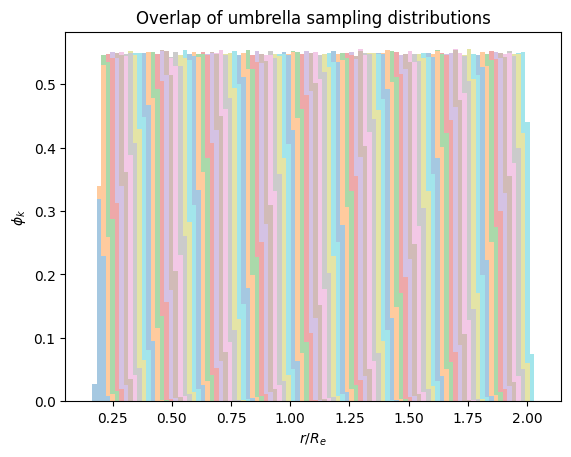

In [6]:
plt.hist(list(map(lambda x: x.flatten(), rad_enss)), stacked=True, density=True, bins=100, alpha=.4)
plt.xlabel("$r/R_e$")
plt.ylabel("$\\phi_k$")
plt.title("Overlap of umbrella sampling distributions")
plt.savefig(figure_dir / "ex1_overlap_umbrella.pdf")

In [7]:
@numba.njit
def dFdr(rad_ens, constraint):
    return -UMBRELLA_CONST * np.mean(rad_ens - constraint)

In [8]:
dFdrs = tqdm.contrib.concurrent.process_map(dFdr, rad_enss, reaction_coordinates)

  0%|          | 0/90 [00:00<?, ?it/s]

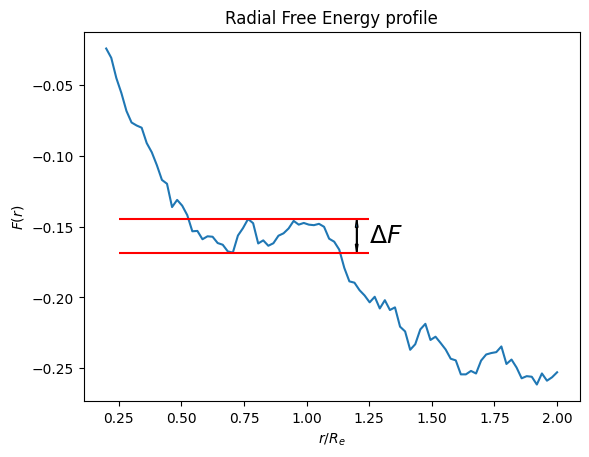

In [9]:
free_energy = np.cumsum(dFdrs) / num_ensembles
masked = free_energy[np.logical_and(reaction_coordinates > .6, reaction_coordinates < 1)]
lower = masked[masked.argmin()]
upper = masked[masked.argmax()]
delta_f = upper - lower

plt.plot(reaction_coordinates, free_energy)
plt.ylabel("$F(r)$")
plt.xlabel("$r/R_e$")
plt.hlines(lower, .25, 1.25, color="r")
plt.hlines(upper, .25, 1.25, color="r")
plt.arrow(1.2, upper, 0, -delta_f, length_includes_head=True, shape="full", head_length=delta_f / 4, head_width=.01)
plt.arrow(1.2, lower, 0, delta_f, length_includes_head=True, shape="full", head_length=delta_f / 4, head_width=.01)
plt.text(1.25, upper - delta_f * .7, "$\\Delta F$", fontsize=18)
plt.title("Radial Free Energy profile")
plt.savefig(figure_dir / "ex1_free_energy_profile.pdf")

In [10]:
np.savetxt(data_dir / "free_energy.dat", np.c_[reaction_coordinates, free_energy])